In [1]:
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
tf.disable_eager_execution()
print(tf.__version__)

import os
#os.environ['COLAB_SKIP_TPU_AUTH'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2.3.1


In [44]:
###

def discount_reward(reward_sequence, gamma, normalization = False):
    ans = [0]
    for ind in reversed(range(len(reward_sequence))):
        ans.append(reward_sequence[ind] + gamma*ans[-1])
    ans = np.array(ans[1:][::-1])
        
    if normalization:
        ans = ans - np.mean(ans)
    return ans

def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """ 
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1) 
    image[image == 109] = 0 # erase background (background type 2) 
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1 
    return np.reshape(image.astype(np.float).ravel(), [80,80,1])

In [45]:
class PGgradient:
    tf.reset_default_graph()
    
    
    def __init__(self, state_size, action_size, lr, name = 'PGNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name = 'input_')
                self.action = tf.placeholder(tf.float32, [None, action_size], name = 'acition')
                self.dc_reward = tf.placeholder(tf.float32, shape = (None), name = 'discounted_reward')
                
            with tf.name_scope("cov"):
                self.cov1 = tf.layers.conv2d(inputs = self.inputs_, filters = 32, kernel_size = [5,5],
                                             strides = [3,3], padding = "SAME",
                                              kernel_initializer = tf.initializers.glorot_uniform(),
                                               name = 'conv1')
                
                self.cov1_batchnorm = tf.layers.batch_normalization(self.cov1, training = True,
                                                                   epsilon=1e-5, name = 'batch_norm1')
                
                self.cov1_out = tf.nn.relu(self.cov1_batchnorm, name = 'conv1_out')
                
                
                #self.cov2 = tf.layers.conv2d(inputs = self.cov1_out, filters = 16, kernel_size = [4,4],
                #                             strides = [2,2], padding = "SAME",
                #                         kernel_initializer = tf.initializers.glorot_uniform(),
                #                           name = 'cov2')
                
                #self.cov2_batchnorm = tf.layers.batch_normalization(self.cov2, training = True,
                #                                                   epsilon=1e-5, name = 'batch_norm2')
                
                #self.cov2_out = tf.nn.relu(self.cov2_batchnorm, name = 'conv2_out')
                
            with tf.name_scope("flatten"):
                self.flatten = tf.layers.flatten(self.cov1_out)
                
            with tf.name_scope("fc"):
                
                self.fc1 = tf.layers.dense(inputs = self.flatten, units = 64, 
                                           activation = tf.nn.relu,
                                          kernel_initializer = tf.initializers.glorot_uniform(),
                                           name = 'fc2')
                
                
                self.logits = tf.layers.dense(inputs = self.fc1, units = action_size, 
                                           activation = None,
                                          kernel_initializer = tf.initializers.glorot_uniform(),
                                           name = 'logits')
                
            
            with tf.name_scope("softmax"):
                self.action_distri = tf.nn.softmax(self.logits)
                
            with tf.name_scope("loss"):
                self.logProbStateAction = tf.nn.softmax_cross_entropy_with_logits(logits = self.logits,
                                                                           labels = self.action)
                
                print(self.logProbStateAction)
                self.negative_weighted_logProb = tf.multiply(self.logProbStateAction, self.dc_reward)
                
                self.negative_object = tf.reduce_mean(self.negative_weighted_logProb)
                
            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.lr)
                self.train_opt = self.optimizer.minimize(self.negative_object)
            
            
        

        

In [46]:
def batch_simu(batch_size, pg, gamma):# this is indeed the sample function from envir
    states = []
    action = []
    reward_episode = []
    reward_seq = []
    discounted_reward_seq = np.array([])
    state = env.reset()
    state = preprocess(state)
    
    batch = 0
    num_episode = 0
    
    while True:
        
        action_prob_distri = sess.run(pg.action_distri, feed_dict ={pg.inputs_: [state]})
        
        action_taken = np.random.choice(range(pg.action_size), p = action_prob_distri[0])
        
        action_onehot = np.zeros(pg.action_size)
        action_onehot[action_taken] = 1
        
        states.append(state)
        action.append(action_onehot) 

        next_state, reward, done, info = env.step(action_taken+2)
        next_state = preprocess(next_state)
        
        reward_episode.append(reward)

        
    
        if not done:
            
            
            state = next_state
                        
            
        else:
            
            state = env.reset()
            state = preprocess(state)
            
            
            reward_seq += reward_episode
            
            discounted_reward_seq = np.concatenate((discounted_reward_seq,
                                                   discount_reward(reward_episode, gamma, True)))
            
            batch += len(reward_episode)
            
            reward_episode = []
            
            num_episode += 1
            
            if batch > batch_size:
                break
    
    
    return states, action, reward_seq, np.array(discounted_reward_seq), num_episode

In [52]:
env =  gym.make('Pong-v0')
tf.reset_default_graph()

pg = PGgradient(state_size= [80, 80,1], action_size=2, lr = 0.0001)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)



Tensor("PGNetwork/loss/softmax_cross_entropy_with_logits_sg/Reshape_2:0", shape=(None,), dtype=float32)


In [53]:
#this is the main training code:


#the discounting rate
gamma = 0.99
batch_size = 1000
num_epoches = 1000
mean_reward = []

epoch = 1

saver = tf.train.Saver()

while epoch < num_epoches+1:
    
    #simulate batch
    states, action, reward_seq, discounted_reward_seq, num_episode= batch_simu(batch_size, pg, gamma)
    meanRewardEpoch = sum(reward_seq)/num_episode
    mean_reward.append(meanRewardEpoch)
    
    #discounted_reward_seq = np.array([np.array([i]) for i in discounted_reward_seq])
    #print(discounted_reward_seq)
    #print(action)
    
    if epoch % 20 == 0:
        print("==================================")
        print("Epoch: ", epoch, "/", num_epoches)
        print("Number of training episode with this batch: ", num_episode)
        print("Mean Reward for episode with this batch: ", meanRewardEpoch)
    
   
    #run the policy gradient
    sess.run([pg.train_opt], feed_dict = {pg.inputs_: states,
                                                         pg.action: action,
                                                         pg.dc_reward: discounted_reward_seq}) 
    
    
    
    epoch += 1
    



Epoch:  20 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -21.0
Epoch:  40 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -20.0
Epoch:  60 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -21.0
Epoch:  80 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -21.0
Epoch:  100 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -20.0
Epoch:  120 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -20.0
Epoch:  140 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -19.0
Epoch:  160 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -19.0
Epoch:  180 / 1000
Number of training episode with this batch:  1
Mean Reward for episode wi

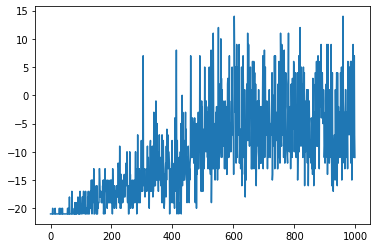

In [54]:
fig, ax = plt.subplots(1,1)

ax.plot(range(num_epoches), mean_reward)

plt.show()


In [55]:
#the discounting rate
gamma = 0.99
batch_size = 1000
num_epoches = 1000
mean_reward2 = []

epoch = 1

saver = tf.train.Saver()

while epoch < num_epoches+1:
    
    #simulate batch
    states, action, reward_seq, discounted_reward_seq, num_episode= batch_simu(batch_size, pg, gamma)
    meanRewardEpoch = sum(reward_seq)/num_episode
    mean_reward2.append(meanRewardEpoch)
    
    #discounted_reward_seq = np.array([np.array([i]) for i in discounted_reward_seq])
    #print(discounted_reward_seq)
    #print(action)
    
    if epoch % 20 == 0:
        print("==================================")
        print("Epoch: ", epoch, "/", num_epoches)
        print("Number of training episode with this batch: ", num_episode)
        print("Mean Reward for episode with this batch: ", meanRewardEpoch)
    
   
    #run the policy gradient
    sess.run([pg.train_opt], feed_dict = {pg.inputs_: states,
                                                         pg.action: action,
                                                         pg.dc_reward: discounted_reward_seq}) 
    
    
    
    epoch += 1
    



Epoch:  20 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -9.0
Epoch:  40 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  10.0
Epoch:  60 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -14.0
Epoch:  80 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -14.0
Epoch:  100 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -11.0
Epoch:  120 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  4.0
Epoch:  140 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  -17.0
Epoch:  160 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with this batch:  5.0
Epoch:  180 / 1000
Number of training episode with this batch:  1
Mean Reward for episode with thi

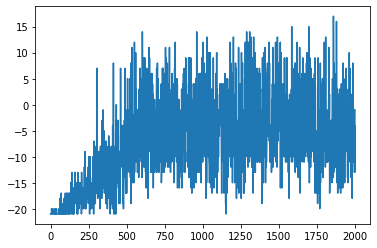

In [58]:
newMeanReward = mean_reward + mean_reward2

fig, ax = plt.subplots(1,1)

ax.plot(range(len(newMeanReward)), newMeanReward)

plt.show()
